In [1]:
import networkx as nx
import pickle
import os
import re
import config as conf
import util_functions as ut
import pandas as pd
import numpy as np
from od_connector import od_cnx

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
cwd = os.getcwd()

Read successful


In [2]:
with open(os.path.join(cwd, 'Data', 'Output_Data', 'G_super.pkl'), 'rb') as inp:
    G_super = pickle.load(inp)

In [3]:
# add t waiting nodes to the nidmap
tw_nodes = [n for n in list(G_super.graph.nodes) if n.startswith('tw')]
for tw in tw_nodes:
    G_super.nid_map[max(G_super.nid_map.keys())+1] = tw

In [4]:
conf.config_data['Reliability_Params']

{'PT_traversal': 1.5,
 'PT_wait': 2,
 'TNC': 1.5,
 'TNC_wait': 2,
 'bike': 1,
 'bs': 1,
 'drive': 1.5,
 'pb': 1,
 'pv': 1.5,
 'scoot': 1,
 'walk': 1,
 'zip': 1.5}

In [5]:
tx_edges = G_super.transfer_edges
pmx = [('ps','ps'),('bsd','ps'),('ps','bsd'),('ps','t'),('t','ps'),('t','bsd'),('bsd','t'), # permitted mode change
           ('k','ps'),('k','t'),('k','bsd'),('ps','pb'),('pb','ps'),('ps','sc'),('sc','ps'),('k','sc'),
           ('bsd','sc'), ('sc','bsd'), ('ps','zd'), ('bsd','zd'), ('t','zd'), ('sc','zd'),
           ('kz','ps'),('kz','t'),('kz','bsd'),('kz','sc')]  

In [6]:
tx_included = set()
digitspattern = r'[0-9]'
# Replace all of the digits in the string with an empty string.
for e in tx_edges.keys():
    mode1 = re.sub(digitspattern, '', e[0])
    mode2 = re.sub(digitspattern, '', e[1])
    tx = (mode1,mode2)
    tx_included.add(tx)    

In [7]:
# for e in G_super.transfer_edges.keys():
#     if e[0].startswith('tw') & e[1].startswith('t'):
#         print(G_super.transfer_edges[e])

In [8]:
conf.config_data['Supernetwork']

{'W_od': 1.0,
 'W_tx': 0.5,
 'dst': [-79.91944888168011, 40.45228774674678],
 'modes_included': ['bs', 'z', 'sc', 't', 'pt'],
 'org': [-79.94868171046522, 40.416379503934145]}

In [9]:
# compile supernetwork with od-connectors
# take the supernetwork as input, then output the supernetwork with od connectors
cwd = os.getcwd()
G_super_od = od_cnx(os.path.join(cwd, 'Data', 'Output_Data', 'G_super.pkl'),
        conf.config_data['Supernetwork']['org'],
        conf.config_data['Supernetwork']['dst'])


7789
7790


In [10]:
# also adjust the inverse nidmap
inv_nid_map = dict(zip(G_super.nid_map.values(), G_super.nid_map.keys()))   

# now convert to link cost file
df_link = nx.to_pandas_edgelist(G_super.graph)
cost_factors = ['avg_TT_sec', 'price', 'risk', 'reliability', 'discomfort']
# check that lal columns are filled out -- complete
for c in cost_factors:
    col_name = '0_'+c
    #print(df_link[col_name].isna().sum())

/home/lgraff/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/lgraff/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1784: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


721


Text(0.5, 0, 'Time (seconds relative to 07:00AM)')

Text(0, 0.5, 'Travel time multiplier \n (relative to baseline)')

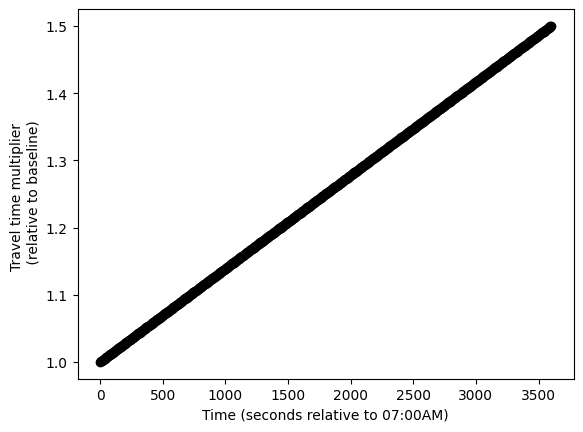

In [11]:
#%%
# Here we build the travel time multiplier as a function of time 
# some arbitary linear function
import matplotlib.pyplot as plt
len_period = int(conf.config_data['Time_Intervals']['len_period'])
num_intervals = int(conf.config_data['Time_Intervals']['len_period'] / conf.config_data['Time_Intervals']['interval_spacing']) + 1
print(num_intervals)
x = np.linspace(0, len_period, num_intervals )  # x is time [min past] relative to 07:00 AM
m = (1.5-1)/len_period # slope
y = m*x + 1
plt.plot(x, y, 'o', color='black', zorder=2);
plt.plot(x, y, color='red', zorder=1);
plt.xlabel('Time (seconds relative to 07:00AM)')
plt.ylabel('Travel time multiplier \n (relative to baseline)')

In [12]:
cost_factors = ['avg_TT_sec', 'price', 'risk', 'reliability', 'discomfort']
cost_factors_0 = ['0_' + c for c in cost_factors]
cols_keep = ['source', 'target', 'mode_type'] + cost_factors_0
df_link = df_link[cols_keep]
cost_factor_cols = [str(i) +'_' + c for c in cost_factors for i in range(1,num_intervals)]
#betas = betas #conf.config_data['Beta_Params']

In [13]:
# for vehicle (non-active) modes, avg_TT_sec, reliability, and price depend on departure time. risk and discomfort are constant
# for active modes (bike, bikeshare, scooter, walk), all cost factors are constant with time
all_modes = df_link.mode_type.unique().tolist()
print(all_modes)

['bs', 'w', 'z', 'sc', 't', 'board', 'alight', 'pt', 't_wait']


In [14]:
cost_attr_df_dict = {'avg_TT_sec':(), 'price':(), 'reliability':(), 'discomfort':(), 'risk':()}

In [15]:
# travel time columns
cost_attr_name = 'avg_TT_sec'
df_var = df_link[['source','target','mode_type','0_'+cost_attr_name]].copy()
interval_cols = [str(n) + '_' + cost_attr_name for n in range(0,num_intervals)]
static_tt_modes = ['bs','w','pb','sc','t_wait','alight']  
dynamic_tt_modes = ['pv','z','t','pt','board']  
tt_multiplier = y.copy()
df_var_all = pd.DataFrame()

for m in dynamic_tt_modes:
    df_m = df_var[df_var['mode_type'] == m].copy()
    data = [tt_multiplier[idx] * df_m['0_' + cost_attr_name] for idx in range(len(interval_cols))]
    data = pd.concat(data, axis=1).set_axis(labels=interval_cols, axis=1)
    data = pd.concat([df_m[['source','target','mode_type']], data], axis=1)
    df_var_all = pd.concat([df_var_all, data], axis=0)

for m in static_tt_modes:
    df_m = df_var[df_var['mode_type'] == m].copy()
    data = [df_m['0_' + cost_attr_name]] *  len(interval_cols)
    data = pd.concat(data, axis=1).set_axis(labels=interval_cols, axis=1)
    data = pd.concat([df_m[['source','target','mode_type']], data], axis=1)
    df_var_all = pd.concat([df_var_all, data], axis=0)

# also create the travel time df in units of 5 second multiples
cost_attr_df_dict['avg_TT_sec'] = df_var_all.copy() 
df_tt_multiple = pd.DataFrame(np.around(cost_attr_df_dict['avg_TT_sec'][interval_cols].to_numpy()/5), columns=interval_cols).astype('int')
df_tt_multiple = pd.concat([cost_attr_df_dict['avg_TT_sec'][['source','target','mode_type']], df_tt_multiple] ,axis=1)
df_tt_multiple.shape

(67478, 724)

In [16]:
# price columns
cost_attr_name = 'price'
df_var = df_link[['source','target','mode_type', '0_avg_TT_sec', '0_'+cost_attr_name]].copy()
interval_cols = [str(n) + '_' + cost_attr_name for n in range(0,num_intervals)]
fixed_price_modes = ['pv','pb', 'pt', 'board', 'alight', 'w','t_wait']  
usage_price_modes = ['z','t','bs','sc']  
usage_prices = conf.config_data['Price_Params']
usage_prices = {'z':usage_prices['zip']['ppmin'], 't':usage_prices['TNC']['ppmin'], 'bs':usage_prices['bs']['ppmin'],
                'sc':usage_prices['scoot']['ppmin']}
tt_multiplier = y.copy()
df_var_all = pd.DataFrame()

for m in usage_price_modes:
    df_m = df_var[df_var['mode_type'] == m].copy()
    data = [df_m['0_' + 'price'] +   # fixed mileage component (for TNC)
                tt_multiplier[idx] * usage_prices[m] / 60 * df_m['0_avg_TT_sec'] for idx in range(len(interval_cols))]
    data = pd.concat(data, axis=1).set_axis(labels=interval_cols, axis=1)
    data = pd.concat([df_m[['source','target','mode_type']], data], axis=1)
    df_var_all = pd.concat([df_var_all, data], axis=0)

for m in fixed_price_modes:
    df_m = df_var[df_var['mode_type'] == m].copy()
    data = [df_m['0_' + cost_attr_name]] *  len(interval_cols)
    data = pd.concat(data, axis=1).set_axis(labels=interval_cols, axis=1)
    data = pd.concat([df_m[['source','target','mode_type']], data], axis=1)
    df_var_all = pd.concat([df_var_all, data], axis=0)

cost_attr_df_dict['price'] = df_var_all.copy()

In [17]:
# reliability
modes = df_link['mode_type'].unique().tolist()
cost_attr_name = 'reliability'
df_var = df_link[['source','target','mode_type', '0_avg_TT_sec', '0_'+cost_attr_name]].copy()
interval_cols = [str(n) + '_' + cost_attr_name for n in range(0,num_intervals)]
rel_weights = conf.config_data['Reliability_Params']
rel_weights = {'pt':rel_weights['PT_traversal'], 'board':rel_weights['PT_wait'], 't':rel_weights['TNC'],
                'pb':rel_weights['pb'], 'pv':rel_weights['pv'], 'sc':rel_weights['scoot'], 'bs':rel_weights['bs'],
                'z':rel_weights['zip'], 'w':rel_weights['walk'], 't_wait':rel_weights['TNC_wait'],
                'sc_wait': 1.25,  # put this in the config file
                'alight':1}
tt_multiplier = y.copy()
df_var_all = pd.DataFrame()  

# special case: scooter transfers 
df_sc_tx = df_var[(df_var['mode_type'] == 'w') & (df_var['target'].str.startswith('sc'))].copy() # filter by rows going TO scooter
data = [df_sc_tx['0_' + cost_attr_name]] *  len(interval_cols)
data = pd.concat(data, axis=1).set_axis(labels=interval_cols, axis=1)
data = pd.concat([df_sc_tx[['source','target','mode_type']], data], axis=1)
df_var_all = pd.concat([df_var_all, data], axis=0)  

# all other transfers / od cnx
# note: we are using df_TT because it already has the time cost for each interval
df_all_other = cost_attr_df_dict['avg_TT_sec'][~((cost_attr_df_dict['avg_TT_sec']['mode_type'] == 'w') & (cost_attr_df_dict['avg_TT_sec']['target'].str.startswith('sc')))]
for m in modes:
    # reliability is defined as reliability_coef * avg_tt, for all intervals
    df_m = df_all_other[df_all_other['mode_type'] == m].copy()
    data = [rel_weights[m] * df_m[str(i) + '_avg_TT_sec'] for i in range(len(interval_cols))]
    data = pd.concat(data, axis=1).set_axis(labels=interval_cols, axis=1)
    data = pd.concat([df_m[['source','target','mode_type']], data], axis=1)
    df_var_all = pd.concat([df_var_all, data], axis=0)

cost_attr_df_dict['reliability'] = df_var_all.copy()
# TO DO: right now, tnc waiting time is constant by departure time. could think about changing it

In [18]:
# add discomfort and risk. assume constant by departure interval
for c in ['discomfort', 'risk']:
    df_var = df_link[['source','target','mode_type','0_' + c]].copy()
    interval_cols = [str(n) + '_' + c for n in range(0,num_intervals)]
    data = [df_var['0_' + c]] *  len(interval_cols)
    data = pd.concat(data, axis=1).set_axis(labels=interval_cols, axis=1)
    data = pd.concat([df_var[['source','target','mode_type']], data], axis=1)
    cost_attr_df_dict[c] = data

In [19]:
for df in cost_attr_df_dict.values():
    df.sort_values(by=['source','target','mode_type'], inplace=True)
betas = conf.config_data['Beta_Params']  

In [20]:
# best to do this in numpy
cost_arrays = {c:() for c in cost_attr_df_dict.keys()}
for c, df in cost_attr_df_dict.items():
    cost_arrays[c] = df.drop(['source','target','mode_type'], axis=1).to_numpy()

# **THIS IS THE STEP THAT MATTERS FOR SENSITIVITY ANALYSIS     
cost_final = (betas['b_TT'] * cost_arrays['avg_TT_sec'] + betas['b_disc'] * cost_arrays['discomfort'] + betas['b_price'] * cost_arrays['price'] 
                + betas['b_rel'] * cost_arrays['reliability'] + betas['b_risk'] * cost_arrays['risk'])

In [21]:
# back to pandas: map the source, target pair to its numerical representation. then append to the left of the array
# map alphanumeric node names to their numeric names
df_G = cost_attr_df_dict['avg_TT_sec'][['source','target']].applymap(lambda x: inv_nid_map[x])
df_G.insert(0, 'linkID', df_G.index)
#%% Prepare files for compatiblity with MAC-POSTS
# 1) Create graph topology file
filename = 'graph'
np.savetxt(filename, df_G, fmt='%d', delimiter=' ')
f = open(filename, 'r')
log = f.readlines()
f.close()
log.insert(0, 'EdgeId FromNodeId ToNodeId\n')
f = open(filename, 'w')
f.writelines(log)
f.close()

# 2) create link cost file 
filename = 'td_link_cost'

linkID_array = df_G['linkID'].to_numpy().reshape((cost_final.shape[0],1))
G_cost_final_array = np.hstack((linkID_array, cost_final))

np.savetxt(filename, G_cost_final_array, fmt='%d ' + (num_intervals-1)*'%f ' + '%f')
f = open(filename, 'r')
log = f.readlines()
f.close()
log.insert(0, 'link_ID td_cost\n')
f = open(filename, 'w')
f.writelines(log)
f.close()

# 3) time-dep travel time for each link and node (just TT, not full cost), in units of 5 second multiples
# i.e. if the TT is 12 seconds, the cell entry is 12/5 = 2.4 ~= 2 (we round to the nearest integer) 
folder = os.getcwd()
G_tt_multiple_array = np.hstack((linkID_array, df_tt_multiple.drop(columns=['source','target','mode_type']).to_numpy()))
G_tt_multiple_array = G_tt_multiple_array.astype('int32')
np.savetxt(os.path.join(folder, 'td_link_tt'), G_tt_multiple_array, fmt='%d ' + (num_intervals-1)*'%f ' + '%f')
f = open(os.path.join(folder, 'td_link_tt'), 'r')
log = f.readlines()
f.close()
log.insert(0, 'link_ID td_tt\n')
f = open(os.path.join(folder, 'td_link_tt'), 'w')
f.writelines(log)
f.close()

In [22]:
# 3) # Create node cost df to prevent org-ps-ps or ps-ps-dst transfers
link_id_map = dict(zip(tuple(zip(df_G['source'], df_G['target'])), df_G['linkID']))
node_costs = []
for n in list(G_super.graph.nodes):
    edges_in = list(G_super.graph.in_edges(n))
    edges_out = list(G_super.graph.out_edges(n))
    for ei in edges_in:
        ei_num = (inv_nid_map[ei[0]], inv_nid_map[ei[1]])
        for eo in edges_out:            
            eo_num = (inv_nid_map[eo[0]], inv_nid_map[eo[1]])
            # prevent consecutive transfers (so avoids ps-ps-ps or bs-ps-ps)
            if ((ut.mode(ei[0]), ut.mode(ei[1])) in G_super.pmx) & ((ut.mode(eo[0]), ut.mode(eo[1])) in G_super.pmx):
                node_costs.append([inv_nid_map[n], link_id_map[ei_num], link_id_map[eo_num]])
            # prevent od_cnx - transfer
            if (ei[0].startswith('org')) & ((ut.mode(eo[0]), ut.mode(eo[1])) in G_super.pmx):  
                node_costs.append([inv_nid_map[n], link_id_map[ei_num], link_id_map[eo_num]])
            # prevent transfer - od_cnx
            if ((ut.mode(ei[0]), ut.mode(ei[1])) in G_super.pmx) & (eo[1].startswith('dst')):  
                node_costs.append([inv_nid_map[n], link_id_map[ei_num], link_id_map[eo_num]])   

df_nodecost = pd.DataFrame(node_costs, columns = ['node_ID', 'in_link_ID', 'out_link_ID'])
# for i in range(num_intervals):
#     df_nodecost['interval'+str(i)+'_COST'] = 100000 # some arbitarily large number to prevent unwanted transfers

# filename = 'td_node_cost'
# np.savetxt(filename, df_nodecost, fmt='%d %d %d ' + (num_intervals-1)*'%d ' + '%d')    # note: i changed last do f's to d's 
# f = open(filename, 'r')
# log = f.readlines()
# f.close()
# log.insert(0, 'node_ID in_link_ID out_link_ID td_cost\n')
# f = open(filename, 'w')
# f.writelines(log)
# f.close()

In [23]:
#np.max(G_cost_final_array[:,3:])
df_nodecost.to_numpy().astype('uint32').dtype
type(df_nodecost)
np.max(df_nodecost.to_numpy())

dtype('uint32')

pandas.core.frame.DataFrame

67222

In [26]:
num_intervals = 100
nodecost_array = np.hstack((df_nodecost.to_numpy().astype('uint32'), np.full((len(df_nodecost), 100), 250, dtype='uint8'))) 
#nodecost_array[:3,:3]
filename = 'td_node_cost'
np.savetxt(filename, nodecost_array, fmt='%d %d %d ' + (num_intervals-1)*'%f ' + '%f')    # note: i changed last do f's to d's 
f = open(filename, 'r')
log = f.readlines()
f.close()
log.insert(0, 'node_ID in_link_ID out_link_ID td_cost\n')
f = open(filename, 'w')
f.writelines(log)
f.close()

: 

: 

In [ ]:
#nodecost_array = np.hstack(df_nodecost.to_numpy(), np.full((len(df_nodecost), num_intervals), 100000, dtype=int)) 

In [ ]:

# # create td_node_tt
# td_node_tt = np.zeros((len(df_nodecost), num_intervals))
# node_ID = df_nodecost[['node_ID', 'in_link_ID', 'out_link_ID']].to_numpy()
# td_node_tt = np.concatenate((node_ID, td_node_tt), axis=1)
# np.savetxt(os.path.join(folder, 'td_node_tt'), td_node_tt, fmt='%d %d %d ' + (num_intervals-1)*'%f ' + '%f')
# f = open(os.path.join(folder, 'td_node_tt'), 'r')
# log = f.readlines()
# f.close()
# log.insert(0, 'node_ID in_link_ID out_link_ID td_tt\n')
# f = open(os.path.join(folder, 'td_node_tt'), 'w')
# f.writelines(log)
# f.close()



In [ ]:
# # travel time
# df_tt = df_link[['source','target','mode_type','0_avg_TT_sec']].copy()
# tt_interval_cols = [str(n) + '_avg_TT_sec' for n in range(0,num_intervals)]

# df_tt_all = pd.DataFrame()
# for m in all_modes:
#     df_m = df_tt[df_tt['mode_type'] == m].copy()
#     if m in dynamic_tt_modes:
#         data = [y[idx] * df_m['0_avg_TT_sec'] for idx in range(len(tt_interval_cols))]
#         data = pd.concat(data, axis=1).set_axis(labels=tt_interval_cols, axis=1)
#         data = pd.concat([df_m[['source','target','mode_type']], data], axis=1)
#     elif m in static_tt_modes:
#         data = [df_m['0_avg_TT_sec']]*len(tt_interval_cols)
#         data = pd.concat(data, axis=1).set_axis(labels=tt_interval_cols, axis=1)
#         data = pd.concat([df_m[['source','target','mode_type']], data], axis=1)
#     df_tt_all = pd.concat([df_tt_all, data], axis=0)

# # also create the travel time df in units of 5 second multiples 
# df_tt_multiple = pd.DataFrame(np.around(df_tt_all[tt_interval_cols].to_numpy()/5), columns=tt_interval_cols).astype('int')
# df_tt_multiple = pd.concat([df_tt_all[['source','target','mode_type']], df_tt_multiple] ,axis=1)
# df_tt_multiple.shape
# df_tt_all.shape

In [ ]:
# # price
# price_usage_modes = ['z','t','bs','sc']
# price_fixed_modes = ['pt','board','alight','pb','w', 'pv']

# usage_prices = conf.config_data['Price_Params']
# usage_prices = {'z':usage_prices['zip']['ppmin'], 't':usage_prices['TNC']['ppmin'], 'bs':usage_prices['bs']['ppmin'],
#                 'sc':usage_prices['scoot']['ppmin']}

# #(TNC_ppmin / 60) * G_tnc.edges[e]['0'+'_avg_TT_sec']

# df_price = df_link[['source','target','mode_type','0_avg_TT_sec', '0_price']].copy()
# price_interval_cols = [str(n) + '_price' for n in range(0,num_intervals)]
# df_price_all = pd.DataFrame()
# for m in df_link.mode_type.unique().tolist():
#     df_m = df_price[df_price['mode_type'] == m].copy()
#     if m in price_usage_modes: 
#         use_price = usage_prices[m] / 60  # [s]
#         data = [y[idx] * use_price * df_m['0_avg_TT_sec'] for idx in range(len(tt_interval_cols))]
#         data = pd.concat(data, axis=1).set_axis(labels=price_interval_cols, axis=1)
#         data = pd.concat([df_m[['source','target','mode_type']], data], axis=1)
#     # elif m == 't':   # TNC exception (recognize the need to account for mileage)
#     #     use_price = usage_prices[m] / 60  #[s]
#     #     # 2 components: time price + static mileage price
#     #     data = [(y[idx] * use_price * df_m['0_avg_TT_sec'] 
#     #              + (df_m['0_price'] - df_m['0_avg_TT_sec'] * use_price)) for idx in range(len(tt_interval_cols))]
#     #     data = pd.concat(data, axis=1).set_axis(labels=price_interval_cols, axis=1)
#     #     data = pd.concat([df_m[['source','target','mode_type']], data], axis=1) 
#     else:
#         data = [df_m['0_price']]*len(price_interval_cols)
#         data = pd.concat(data, axis=1).set_axis(labels=price_interval_cols, axis=1)
#         data = pd.concat([df_m[['source','target','mode_type']], data], axis=1)
#     df_price_all = pd.concat([df_price_all, data], axis=0)
    